<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/1p19qSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Cell 1
!pip install pandas

import numpy as np
import numpy.ma as ma
import os
import shutil
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.engine.topology import Layer

from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from natsort import natsorted
import random
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import nibabel as nib

!rm -rf trainimages
!mkdir trainimages
!rm -rf trainmasks
!mkdir trainmasks

!rm -rf validationimages
!mkdir validationimages
!rm -rf validationmasks
!mkdir validationmasks

!rm -rf testimages
!mkdir testimages
!rm -rf testmasks
!mkdir testmasks

print("Tensorflow version: " + str(tf.__version__))


Using TensorFlow backend.


Tensorflow version: 1.15.0


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Feb 23 14:55:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:

# get the csv file describing images
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pazXvT4N9-T4OAxcuUiuCd3AUmDaAAxF' -O ./data.csv
#DATA_FILE = "./data.csv"
#IMAGE_DIR = './Nifti'
# then get the images
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V4zAE19E1kLUK0Z0YIWNpMq0K8lOARtu' -O ./images.zip
#!unzip -q -o "./images.zip"


In [3]:
from google.colab import drive
drive.mount('/content/drive')

DATA_FILE = '/content/drive/My Drive/LGG-1p19q/TCIA_LGG_cases_info.csv'
IMAGE_DIR = '/content/drive/My Drive/LGG-1p19q/Nifti/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# read and process the csv file to find tumor and annotation slices

df = pd.read_csv(DATA_FILE)
print (df)


    Filename 1p19q  Grade  ... TopOfTumor  BottomOfTrace  TopOfTrace
0    LGG-104   d/d    3.0  ...       47.0           39.0        41.0
1    LGG-203   n/n    3.0  ...       44.0           29.0        31.0
2    LGG-210   n/n    2.0  ...       12.0            8.0        12.0
3    LGG-216   d/d    2.0  ...       35.0           31.0        33.0
4    LGG-218   d/d    2.0  ...       40.0           35.0        37.0
..       ...   ...    ...  ...        ...            ...         ...
993      NaN   NaN    NaN  ...        NaN            NaN         NaN
994      NaN   NaN    NaN  ...        NaN            NaN         NaN
995      NaN   NaN    NaN  ...        NaN            NaN         NaN
996      NaN   NaN    NaN  ...        NaN            NaN         NaN
997      NaN   NaN    NaN  ...        NaN            NaN         NaN

[998 rows x 8 columns]


In [0]:
DIM = 256

def load_nifti(fname):
    # print (fname)
    nifti = nib.load(fname)
    image = nifti.get_fdata()
    dims = np.shape(image)
    xd = dims[0]
    yd = dims[1]
    zd = dims[2]
    if xd > DIM or yd > DIM:  # these are all
        new_image = np.zeros(shape=(DIM, DIM, zd), dtype = np.float64)
        print ("Resizing " + str(fname) + " from " + str(xd) + " x " + str(yd))
        for z in range (0, zd):
            for W in range(DIM):
                for H in range(DIM):
                    new_image[H][W][z] = image[2*H][2*W][z]
        xd = yd = DIM
        image = new_image
#        nifti.set_data_shape((xd, yd, zd))
#        new_name = str.replace(fname, ".nii", "resize.nii")
#        nib.save(image, new_name)
    if (image.max() > 10): # only normalize images, not masks
        image.reshape(xd*yd*zd)
        image = image - np.min(image)
        image = (np.maximum(image, 30) / image.max()) * 255.0
    image.reshape(DIM, DIM, zd)
    dims = np.shape(image)
    if (dims[0] != DIM):
        print ("wrong order")
    return image, nifti

In [6]:
Images = []
Seg_images = []

#studies with 512 matrix: 310, 326, 387, 515

for ind in df.index: 
    if 'LGG' in str(df['Filename'][ind]):
        Dir = os.path.join (IMAGE_DIR, df['Filename'][ind])
        T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1.nii.gz')
        if not os.path.exists(T1_file):
            T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1c.nii.gz')
        T2_file = os.path.join (Dir, df['Filename'][ind] + '_T2.nii.gz')
        Seg_file = os.path.join (Dir, df['Filename'][ind] + '-Segmentation.nii.gz')
        Chromosome_status = str(df['1p19q'][ind])
        Grade = int(df['Grade'][ind])
        Type = str(df['Type'][ind])
        BottomOfTumor = int(df['BottomOfTumor'][ind])
        TopOfTumor = int(df['TopOfTumor'][ind])
        BottomOfTrace = int(df['BottomOfTrace'][ind])
        TopOfTrace = int(df['TopOfTrace'][ind])
#            print (T1_file + ' size: ' + str(os.path.getsize(T1_file)))
        T1, hdr = load_nifti(T1_file)
        T2, hdr = load_nifti(T2_file)
        Seg, hdr = load_nifti(Seg_file)
#Store the training slices into the arrays
# note the slice number start from 1 in ITK-Snap, so must start/stop at 1 less
        for slc in range (BottomOfTrace-1, TopOfTrace):
            # combine the T1 and T2 images
            image = np.dstack((T1[:,:, slc], T2[:,:, slc]))
            # append them onto prior images
            Images.append (image)
            # print ("Sg min: " + str(Seg[:,:, slc].min()) + " max: " + str(Seg[:,:, slc].max()) + " count: " + str(Seg[:,:, slc].sum()))
            Seg_images.append (Seg[:,:, slc])
        print ("Processed " + Dir)

Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-104
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-203
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-210
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-216
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-218
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-219
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-220
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-225
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-229
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-231
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-233
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-234
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-240
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-241
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-246
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-249
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-254
Processed /con

In [7]:
# Cell 2
print (str(len(Images)) + " total labeled images.")
Images = np.asarray(Images)
Seg_images = np.asarray(Seg_images)
total = len(Images)
Num_Train = int(0.8 * total)
Num_Val = int(0.1 * total)
Num_Test = total - Num_Train - Num_Val
train_X = []
train_Y = []
val_X = []
val_Y = []
test_X = []
test_Y = []

train_X = np.asarray(Images[0:Num_Train, :,:])
train_X = train_X/255
#train_X = train_X[..., np.newaxis]

train_Y = Seg_images[0:Num_Train, :,:]
train_Y = (train_Y > 0).astype(np.float32)
#train_Y = train_Y[..., np.newaxis]
train_Y=np.expand_dims(train_Y, axis=-1)
val_X = Images[Num_Train:Num_Train+Num_Val, :,:]
val_X = val_X/255
#val_X = val_X[..., np.newaxis]

val_Y = Seg_images[Num_Train: Num_Train + Num_Val, :,:]
val_Y = (val_Y > 0).astype(np.float32)
#val_Y = val_Y[..., np.newaxis]
val_Y=np.expand_dims(val_Y, axis=-1)

test_X = Images[-Num_Test:, :,:]
test_X = test_X/255
#test_X = test_X[..., np.newaxis]

test_Y = Seg_images[-Num_Test:, :,:]
test_Y = (test_Y > 0).astype(np.float32)
#test_Y = test_Y[..., np.newaxis]
test_Y=np.expand_dims(test_Y, axis=-1)
print(train_X.shape[0],"images for training,", val_X.shape[0], "images for validation, and", test_X.shape[0], "images for testing")

WIDTH = train_X.shape[2]
HEIGHT = train_X.shape[1]
CHANNELS = train_X.shape[3]
print ('X and Y dims are ' + str(WIDTH) + 'x' + str(HEIGHT) + " Channels: " + str(CHANNELS))
print (train_X.shape)
print (test_Y.shape)


699 total labeled images.
559 images for training, 69 images for validation, and 71 images for testing
X and Y dims are 256x256 Channels: 2
(559, 256, 256, 2)
(71, 256, 256, 1)


In [0]:
# Cell 3
def dice_coeff(y_true, y_pred):
    # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
    # we only care about relative value, not absolute so this alteration doesn't matter
    # y_true = tf.expand_dims(y_true, axis=-1)
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
#    y_true = tf.expand_dims(y_true, axis=-1)
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
get_custom_objects().update({"dice": dice_loss})

class LayerNormalization (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        x /= K.std (x, axis = axis, keepdims = True) + K.epsilon()
        x -= K.mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
# Cell 4
def build_model(act_fn = 'relu', init_fn = 'he_normal', width=256, height = 256, channels = 2): 
    inputs = Input((width,height,channels))

    # note we use linear function before layer normalization
    conv1 = Conv2D(8, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#    pool1 = Dropout(0.1)(pool1)
    conv2 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#    pool2 = Dropout(0.1)(pool2)
    conv3 = Conv2D(32, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(72, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)

    up6 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)

    up7 = Conv2D(32, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)

    up8 = Conv2D(16, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)

    up9 = Conv2D(8, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics=[dice_coeff])
    return model

def build_good_model(act_fn = 'relu', init_fn = 'he_normal', width=256, height = 256, channels = 2): # this gets dice 0.84 at 200 epochs
    inputs = Input((width,height,channels))

    # note we use linear function before layer normalization
    conv1 = Conv2D(8, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#    pool1 = Dropout(0.1)(pool1)
    conv2 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#    pool2 = Dropout(0.1)(pool2)
    conv3 = Conv2D(32, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(72, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)

    up6 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)

    up7 = Conv2D(32, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)

    up8 = Conv2D(16, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)

    up9 = Conv2D(8, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics=[dice_coeff])
    return model


In [10]:
# Cell 5
model = build_model(act_fn = 'relu', init_fn = 'he_normal', width=WIDTH, height = HEIGHT, channels = CHANNELS)

checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

epochs = 100
batch_size = 64
results = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Train on 559 samples, validate on 69 samples
Epoch 1/100





559/559 [==============================] - 19s 34ms/step - loss: 0.9340 - dice_coeff: 0.0660 - val_loss: 0.9582 - val_dice_coeff: 0.0418

Epoch 00001: val_loss improved from inf to 0.95819, saving model to model.h5
Epoch 2/100
559/559 [==============================] - 2s 4ms/step - loss: 0.9168 - dice_coeff: 0.0832 - val_loss: 0.9484 - val_dice_coeff: 0.0516

Epoch 00002: val_loss improved from 0.95819 to 0.94840, saving model to model.h5
Epoch 3/100
559/559 [==============================] - 2s 4ms/step - loss: 0.8922 - dice_coeff: 0.1078 - val_loss: 0.9269 - val_dice_coeff: 0.0731

Epoch 00003: val_loss improved from 0.94840 to 0.92691, saving model to model.h5
Epoch 4/100
559/559 [==============================] - 2s 4ms/step - loss: 0.8455 - dice_coeff: 0.1545 - val_loss: 0.8940 - val_dice_coeff:

71/71 [==============================] - 0s 2ms/step


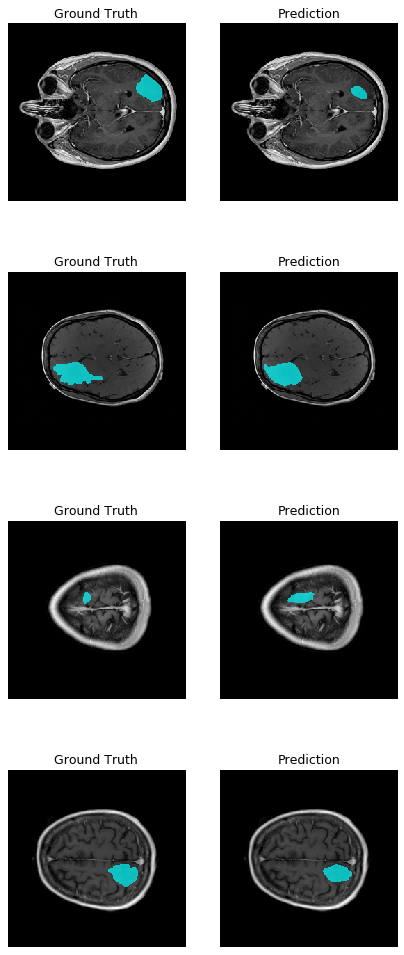

The dice score for this model is:  0.7943298923318628


In [14]:
# Cell 6

model.load_weights("./model.h5")
preds_test = model.predict(test_X, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)


from skimage.measure import label

def getLargestCC(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    largest=max(list_seg, key=lambda x:x[1])[0]
    labels_max=(labels == largest).astype(np.uint8)
    return labels_max

def np_dice(true, pred):
    intersection = np.sum(true * pred)
    dc =(2.0 * intersection) / (np.sum(true) + np.sum(pred))
    return dc

fig=plt.figure(figsize=(130, 130), dpi = 75)

for j in range(0,8,2):
    i = random.randint(0,test_X.shape[0]-1)
    image = test_X[i,...,0]
    mask =  test_Y[i,...,0]
    mask = ma.masked_where(mask == 0, mask)
    pred = preds_test[i,...,0]
    pred = getLargestCC(pred)
    pred = ma.masked_where(pred == 0, pred)
    
    fig.add_subplot(8, 2, j+1)
    plt.imshow(image, cmap = "gray")
    plt.imshow(mask, 'cool', alpha=0.7)
    plt.title("Ground Truth")
    plt.axis('off')
    
    fig.add_subplot(8, 2, j+2)
    plt.imshow(image, cmap = "gray")
    plt.imshow(pred, 'cool', alpha=0.7)
    plt.title("Prediction")
    plt.axis('off')
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()

print("The dice score for this model is: ", np_dice(test_Y, preds_test))

In [31]:
# now go back through and segmented the unlabeled slices
df = pd.read_csv(DATA_FILE)

for ind in df.index: 
    if 'LGG' in str(df['Filename'][ind]):
        Dir = os.path.join (IMAGE_DIR, df['Filename'][ind])
        T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1.nii.gz')
        if not os.path.exists(T1_file):
            T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1c.nii.gz')
        T2_file = os.path.join (Dir, df['Filename'][ind] + '_T2.nii.gz')
        Seg_file = os.path.join (Dir, df['Filename'][ind] + '-Segmentation.nii.gz')
        Chromosome_status = str(df['1p19q'][ind])
        Grade = int(df['Grade'][ind])
        Type = str(df['Type'][ind])
        BottomOfTumor = int(df['BottomOfTumor'][ind])
        TopOfTumor = int(df['TopOfTumor'][ind])
        BottomOfTrace = int(df['BottomOfTrace'][ind])
        TopOfTrace = int(df['TopOfTrace'][ind])
#            print (T1_file + ' size: ' + str(os.path.getsize(T1_file)))
        T1, hdr = load_nifti(T1_file)
        T2, hdr = load_nifti(T2_file)
        Seg, hdr = load_nifti(Seg_file) # note saving the header for later use
#Store the training slices into the arrays
# note the slice number start from 1 in ITK-Snap, so must start/stop at 1 less

        nImages = []
        if BottomOfTrace < BottomOfTumor or TopOfTrace > TopOfTumor or TopOfTumor-BottomOfTumor<3:
            print ("Error in CSV on " + str(T2_file) + str(BottomOfTumor) + ", "+ str(BottomOfTrace)+ ", "+ str(TopOfTrace)+ ", "+ str(TopOfTumor))
            pass
        for slc in range (BottomOfTumor-1, TopOfTumor):
            # combine the T1 and T2 images
            image = np.dstack((T1[:,:, slc], T2[:,:, slc]))
            nImages.append (image)
#            print (str(slc))
        nImages = np.asarray(nImages)
        preds = model.predict(nImages, verbose=1)
        preds = (preds > 0.5).astype(np.uint8)

 #       msk = []
 #       for slc in range (BottomOfTumor-1, TopOfTumor):
 #           msk = np.append(preds[slc-BottomOfTumor+1,...,0])

        preds = preds[:,:,:,0]
        msk = getLargestCC(preds)
        msk = ma.masked_where(msk == 0, msk)

        for slc in range(BottomOfTumor-1, TopOfTumor):
            Seg[:,:,slc] = msk[slc-BottomOfTumor+1,:,:]
        Seg = np.array(Seg, dtype=np.int16)
        fname = os.path.join (Dir, df['Filename'][ind] + '-NewSegmentation.nii.gz')
#        print ("Saving " + fname)
        nib.save(nib.Nifti1Image(Seg, hdr.affine, hdr.header), fname)
        print ("Processed " + Dir)

14/14 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-104
24/24 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-203
5/5 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-210
12/12 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-216
8/8 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-218
7/7 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-219
12/12 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-220
11/11 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-225
8/8 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-229
12/12 [==